# Forecasting average temperatures in European Cities
Using historical weather data of major European cities to forecast future average temperature.  

In [2]:
import numpy as np
import pandas as pd
import datetime
import itertools

# plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# checking seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# predictive models 
#from sktime.forecasters import ARIMAForecaster
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from statsmodels.tsa.ar_model import AR

# evaluation tools 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# import warnings to ignore them 
import warnings
warnings.filterwarnings("ignore")

### Loading the data

In [3]:
# global variable target = AverageTemperature 

target = 'AverageTemperature'

In [4]:
# loading a dataset that contains all global temperature data by city

df = pd.read_csv('GlobalLandTemperaturesByCity.csv', index_col=0)

In [6]:
# casting index to detetime 
df.index = pd.to_datetime(df.index)

# creating new columns based on year, month

df['year'] = df.index.year
df['month'] = df.index.month

In [7]:
# creating a list of dataframes containing European capitals 

capitals = ['Helsinki', 'Berlin', 'Rome']

capital_frames = []

for capital in capitals:
    capital = df[df['City'] == capital]
    capital_frames.append(capital.loc['1760-01-01':])

In [37]:
# plotting function to show temp developements of several European cities

def plot_it(capital_list):
    """takes a list of capital frames and plots the temperature deveopment"""
    plt.figure(figsize=(14,8))
    for capital in capital_list:
        yearly_average = capital.groupby('year')['AverageTemperature'].mean()
        yearly_average.plot(label=capital["City"][0])
    plt.ylim(-1,15)
    plt.title("Average temperature per year in European cities")
    plt.grid()
    plt.savefig("historical_temperature_europe.png")
    plt.legend()

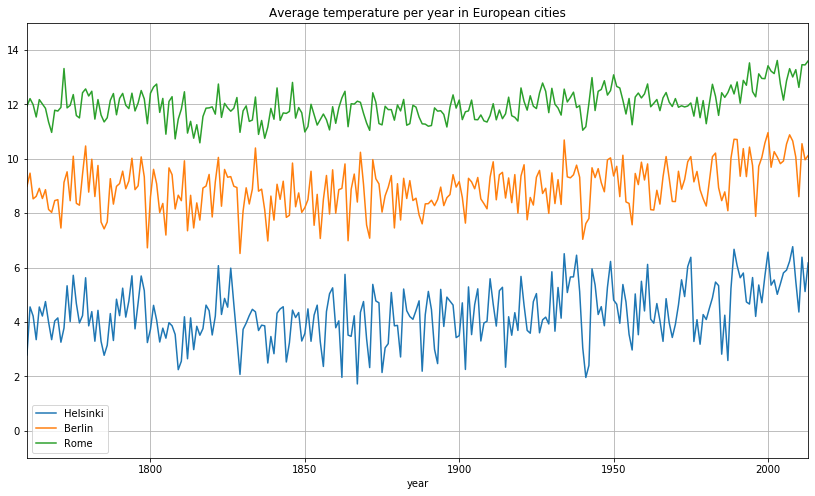

In [38]:
plot_it(capital_frames)

### Focussing on Berlin

In [10]:
# look at only Berlin 

brln = df[df['City'] == 'Berlin']

### Creating functions to transform data and add changes over time to dataframe

In [11]:
# defining a fucntion to decompse time series

def temp_framer(dataset):
    """function to decompose time series.
    Creates a dataframe with:
    - diff to last value, pct_change, and seasonal changes to -12 months
    """
    # creating empty dataframe and setting Series as temp column
    temp_frame = pd.DataFrame()
    
    # naming temp coulmn
    temp_frame[target] = dataset[target] 
    
    temp_frame['diff'] = temp_frame[target].diff()
    temp_frame['pct_change'] = temp_frame[target].pct_change()
    
    # describing the seasonality  
    temp_frame['saisonality'] = temp_frame[target].shift(12)
    return temp_frame

In [12]:
# model fitting function 

def linreg_fitter(dataset):
    """Takes dataset, removes NaNs, reshapes it for processing and 
    fits a lin reg model on it. 
    Output: trained model"""
    
    # 'de_seasoned' = target, the time series-decomposed temperature
    X_clean = temp_framer(dataset).dropna()
    
    # putting time series index in array to be able to reshape it 
    X_cleanarray = np.array(X_clean[target]).reshape(-1, 1)
    
    # instanciates model
    linreg = LinearRegression()
    
    # fits model temp value 12 months ago
    linreg.fit(X_cleanarray, X_clean['saisonality'])
    
    # returns model 
    return linreg

In [13]:
# predicting function with linear regression

def model_predictor(pipeline_model, testdata):
    """takes pre-trained model and test data, adjusts test data and
    returns a dataframe with predictions"""
    
    # processes test data to remove trend and show seasonality 
    test_frame = temp_framer(testdata)
    
    # removing missing values 
    test_frame = test_frame.dropna()
    
    # casting test data to 2D array so it works with model
    test_clean = np.array(test_frame['saisonality']).reshape(-1,1)
    
    # predicting pure y_pred
    y_pred = pipeline_model.predict(test_clean)
    
    # adding y_pred to original dataframe 
    test_frame['pred'] = y_pred
    
    return test_frame

In [14]:
def evaluator(y_test, y_pred):
    """takes a dataframe with prediction results and evaluates accuracy of predicted values"""
    print(f"Mean Absolute Error is {mean_absolute_error(y_test, y_pred)}") 
    print(f"Mean Squared Error is {mean_squared_error(y_test, y_pred)}")

In [15]:
# defining a plotting function 

def pred_plotter(pred_frame): 
    """needs predictions within a dataframe w correct datetime-index.
    output: plot w true, predicted values & confidence interval"""
    fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
    pred_frame[target].plot(ax=ax, label='true values')
    pred_frame['pred'].plot(ax=ax, label='predicted values')
    ax.fill_between(pred_frame.index,
                pred_frame.loc[:, 'lower AverageTemperature'],
                pred_frame.loc[:, 'upper AverageTemperature'], color='k', alpha=0.25)
    ax.set()
    plt.legend()

In [16]:
# autoregressor predictor function 

def ar_predictor(dataset):
    ytrain = dataset.loc[:,target]
    ar = AR(ytrain)  
    # fitting model
    ar_fitted = ar.fit()  
    # creating y pred values 
    ypred = ar_fitted.predict(end='2013-08-01')
    # conf_int = ar_fitted.conf_int() 
    dataset['pred'] = ypred
    #dataset.dropna(inplace=True)
    return dataset

In [17]:
# arima model fitter 

def arima_fitter(dataset): 
    mod = sm.tsa.statespace.SARIMAX(train[target],
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
    results = mod.fit()
    return results

In [18]:
# function that forecasts with SARIMA 

def arima_forecaster(dataframe, until):
    """Takes a dataframe with timeseries & temperatures, fits ARIMA model.
    creates predicitons and outputs them."""
    
    # fitting model with gridsearched best order and seasonal order hyperparameters
    mod = sm.tsa.statespace.SARIMAX(dataframe[target],
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=True)
    
    results = mod.fit()
    
    # makes predictions starting with last step in training set and until specified step in argument
    arima_pred = results.get_prediction(start=dataframe.index[-1], 
                                        end=pd.to_datetime(until),
                                        dynamic=True)
    
    # forecasting values with timeseries index
    forecast = arima_pred.predicted_mean
    
    # finding confidence intervals and defining a DataFrame 
    confidence = pred_ci = arima_pred.conf_int()
    forecast = pd.DataFrame(data=forecast, columns=['pred'])
    
    # new dataframe containing predicted values and confidence intervals
    capital = pd.concat([capital, forecast, confidence], axis= 1)
    return capital

In [19]:
# forecast plotting function 

def forecast_plotter():
    ax = test[target].plot(label='Observed', figsize=(20, 15))
    pred_dynamic.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=0.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature')

    plt.legend()
    plt.show()

### Forecasting with train and test data

In [20]:
# quick train test 
train = brln.loc['1950-01-01':'2008-01-01']
test = brln.loc['2008-02-01':]

In [21]:
train_model = linreg_fitter(train)

In [22]:
lin_frame = model_predictor(train_model, test)

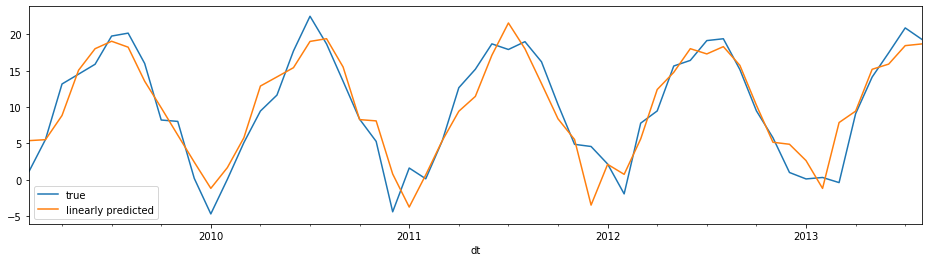

In [23]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
lin_frame['AverageTemperature'].plot(ax=ax, label='true')
lin_frame['pred'].plot(ax=ax, label='linearly predicted')
ax.set()
plt.legend()

In [24]:
evaluator(lin_frame[target], lin_frame['pred'])

Mean Absolute Error is 2.195477559540831
Mean Squared Error is 7.898100180234256


### Autoregressor forecasting & evaluating

In [25]:
ar_frame = ar_predictor(train).dropna()

In [26]:
evaluator(ar_frame[target], ar_frame['pred'])

Mean Absolute Error is 1.5317788599130142
Mean Squared Error is 3.886256496306378


### ARIMA forecasting & evaluating

In [27]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [28]:
# creating a list of pdq and seasonal pdq combinations and their respective AIC scores

pdq_AIC_scores = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train[target],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            pdq_AIC_scores.append((param, param_seasonal, results.aic))
        except:
            continue
            


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5405.865769525322
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:4634.536455200095
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3275.3089222547665
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2864.272465556278
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3273.731036895921
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2914.0826723937344
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3077.4153482607944
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2871.8285817098645
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:4682.653108200984
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:4200.553089157989
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3252.45473050928
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2824.0705095592034
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3252.130622924102
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2874.845317093461
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3053.1801977799523
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2826.069120083095
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:3979.745816257373
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:3690.3991797059384
ARIM

In [29]:
# best gridsearch result: ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2336.7329987040753

mod = sm.tsa.statespace.SARIMAX(train[target],
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6100      0.114      5.362      0.000       0.387       0.833
ma.L1         -0.3847      0.129     -2.993      0.003      -0.637      -0.133
ma.S.L12      -1.0483      0.021    -50.595      0.000      -1.089      -1.008
sigma2         3.3742      0.180     18.787      0.000       3.022       3.726


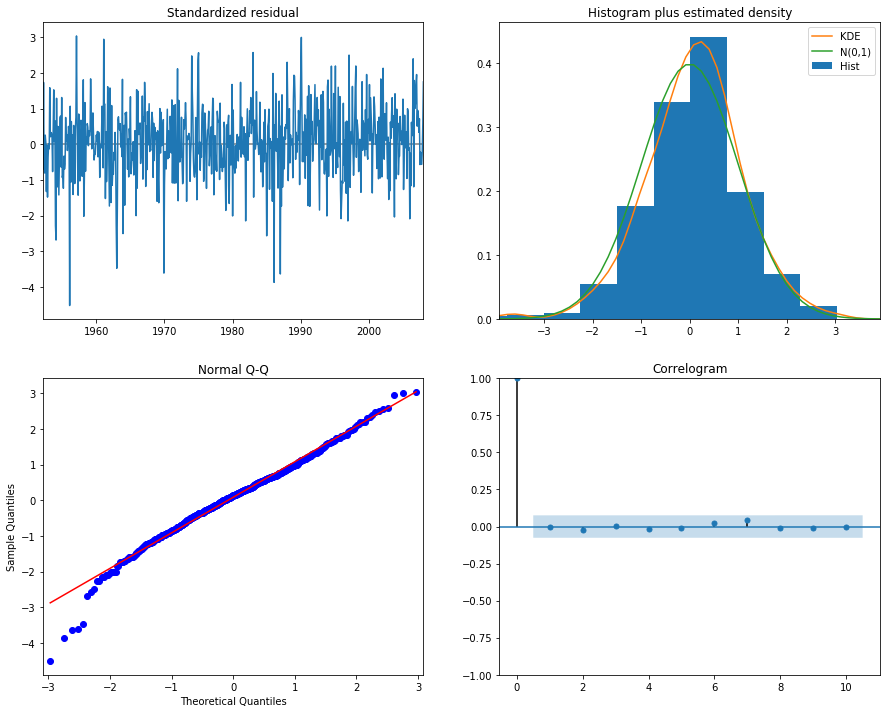

In [39]:
results.plot_diagnostics(figsize=(15, 12))
plt.savefig("SARIMAXmodel_predictivequality.png")
plt.show()

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2008-02-01'), dynamic=False)
pred_ci = pred.conf_int()

In [32]:
arima_pred = results.get_prediction(start=pd.to_datetime('2008-02-01'), end=pd.to_datetime('2013-08-01'), dynamic=False)

In [33]:
evaluator(test[target].dropna(), arima_pred.predicted_mean)

Mean Absolute Error is 1.3455584698914334
Mean Squared Error is 3.610654055893225


In [34]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2010-02-01'), end=pd.to_datetime('2025-02-01'), 
                                      dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [35]:
# forcast x steps into the future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

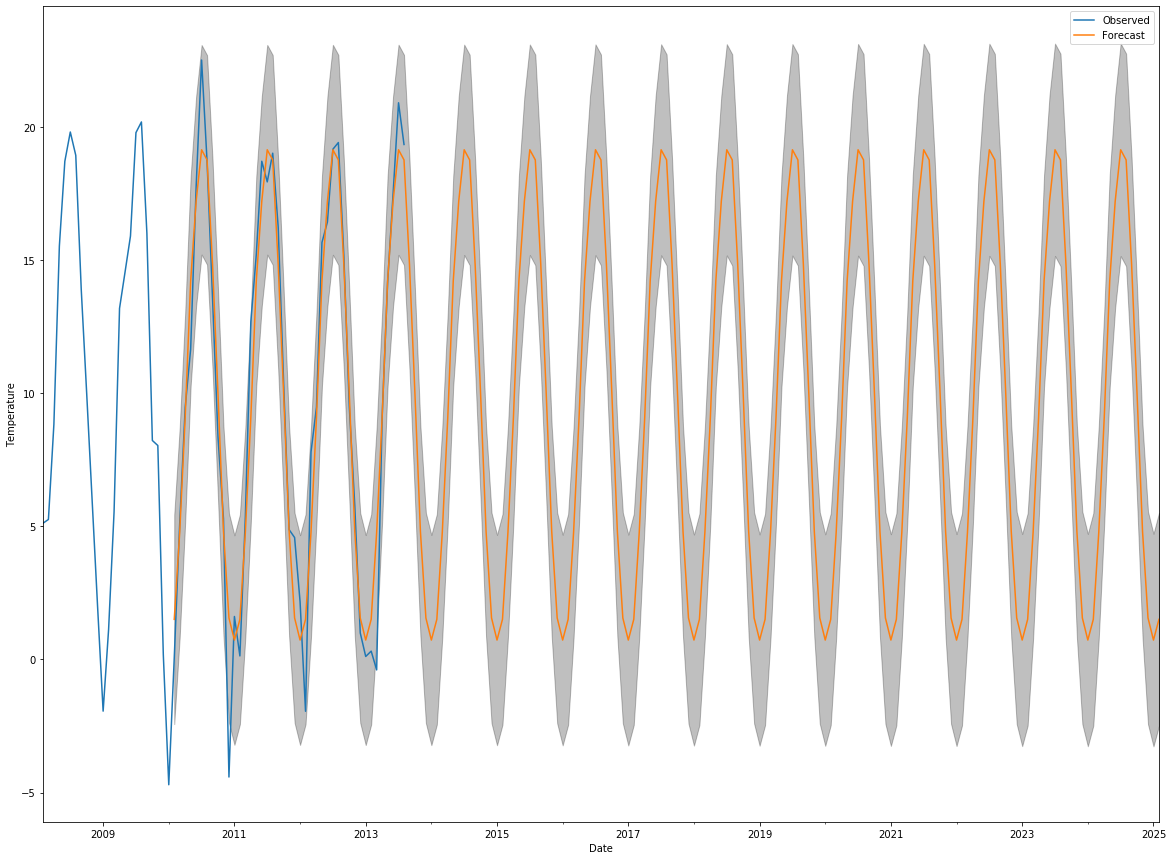

In [36]:
forecast_plotter()